# Setup

In [1]:
%load_ext autoreload

In [7]:
%autoreload
from helpers import *
N=50
problem = DirectProblem(N)
V = problem.V
V_array_size = V.dofmap.index_map.size_global

# Noised data

In [23]:
c = dolfinx.fem.Function(V)
const = 40
c.interpolate(lambda x: 1-const*(x[0]-0.5)**2-const*(x[1]-0.5)**2)
c.x.array[:] = np.where(c.x.array>=0, c.x.array, 0)
# problem.plotFunc(c,warped=True)

## 1 Equation

Plot fi:


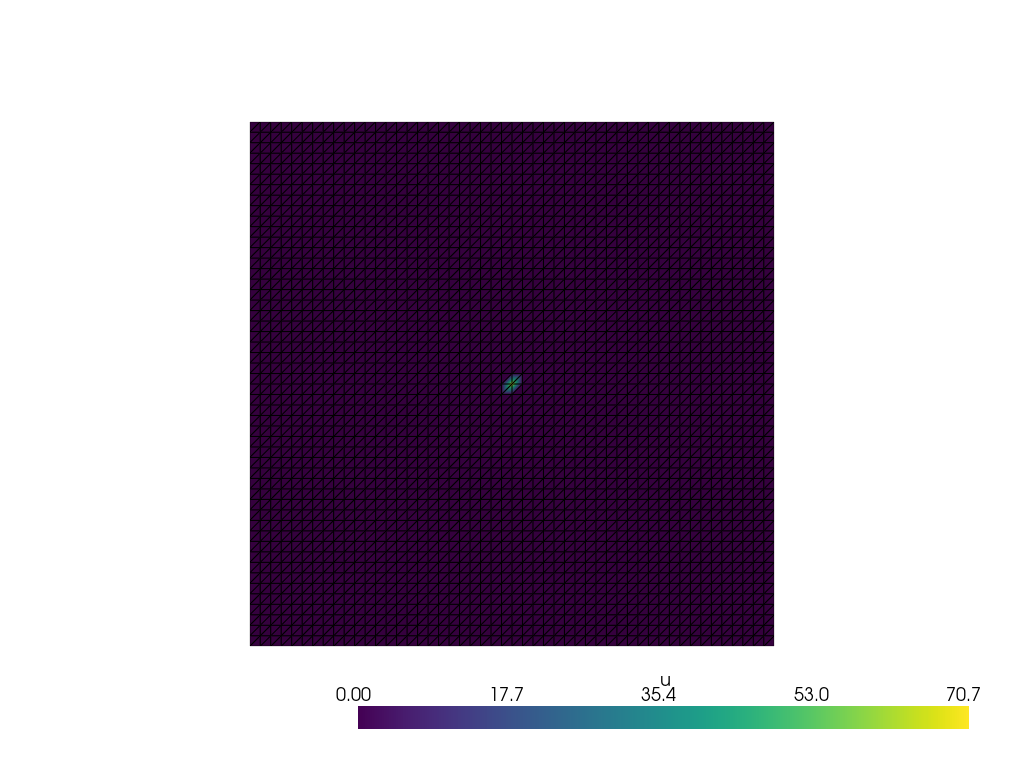

Plot u:


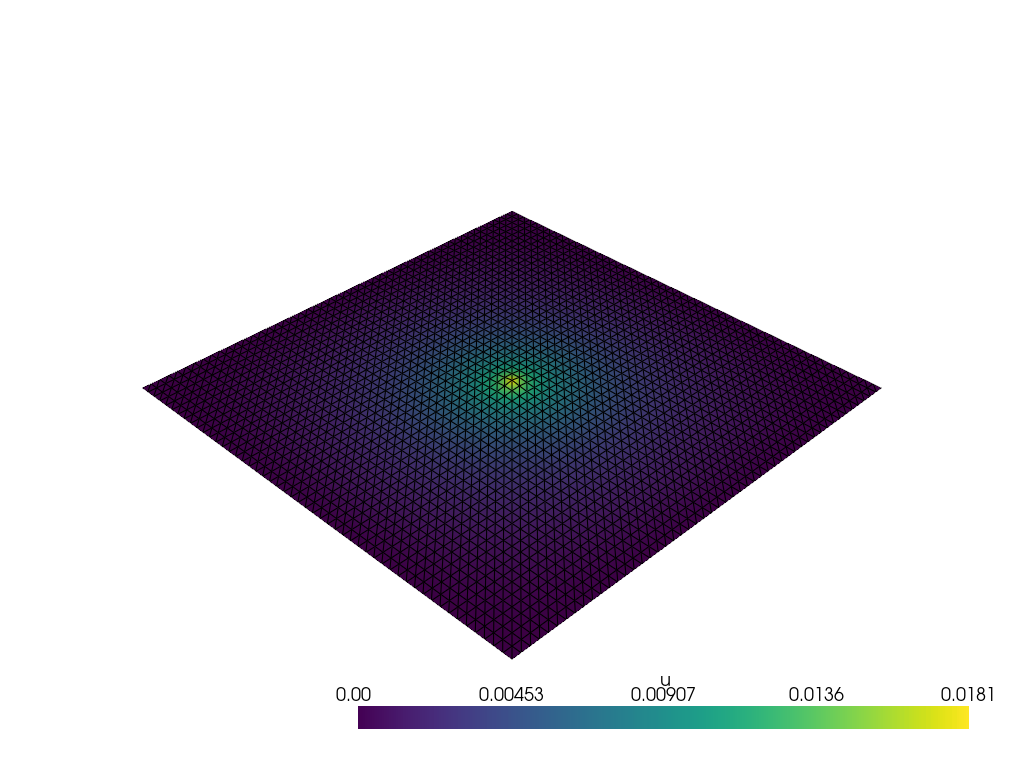

In [46]:
fi = dolfinx.fem.Function(V)
fi.x.array[problem.M_id[(N+1)//2][(N+1)//2]] = 1
fi_norm = funcSquareNorm(fi)**0.5
fi.x.array[problem.M_id[(N+1)//2][(N+1)//2]] /= fi_norm
print("Plot fi:")
problem.plotFunc(fi)

u = problem.solveDirect(c,fi)
print("Plot u:")
problem.plotFunc(u,warped=True)

#Test if changing functions affects solutions
# fi.x.array[problem.M_id[(N+1)//2][(N+1)//2]] *= -1
# u = problem.solveDirect(c,fi)
# print("Plot u:")
# problem.plotFunc(u,warped=True)

### Adding noise

In [47]:
# Gen noise array
perc = 1
noise_vec = np.random.uniform(-1,1,V_array_size)

Plot of u^delta


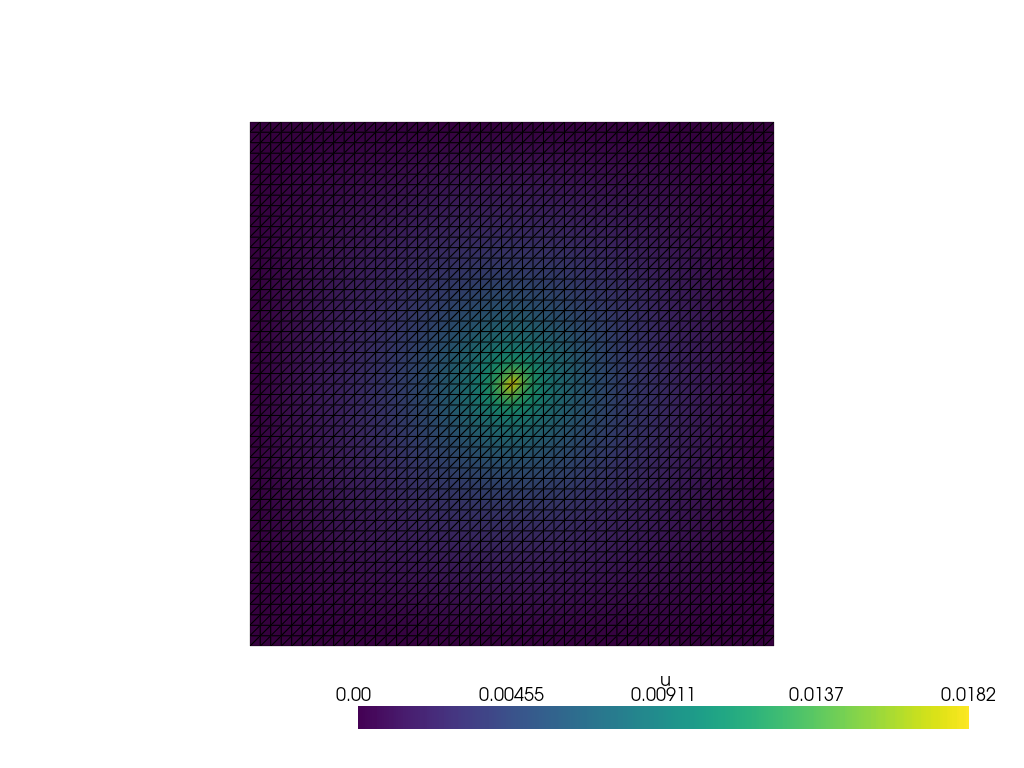

Plot u-u^delta


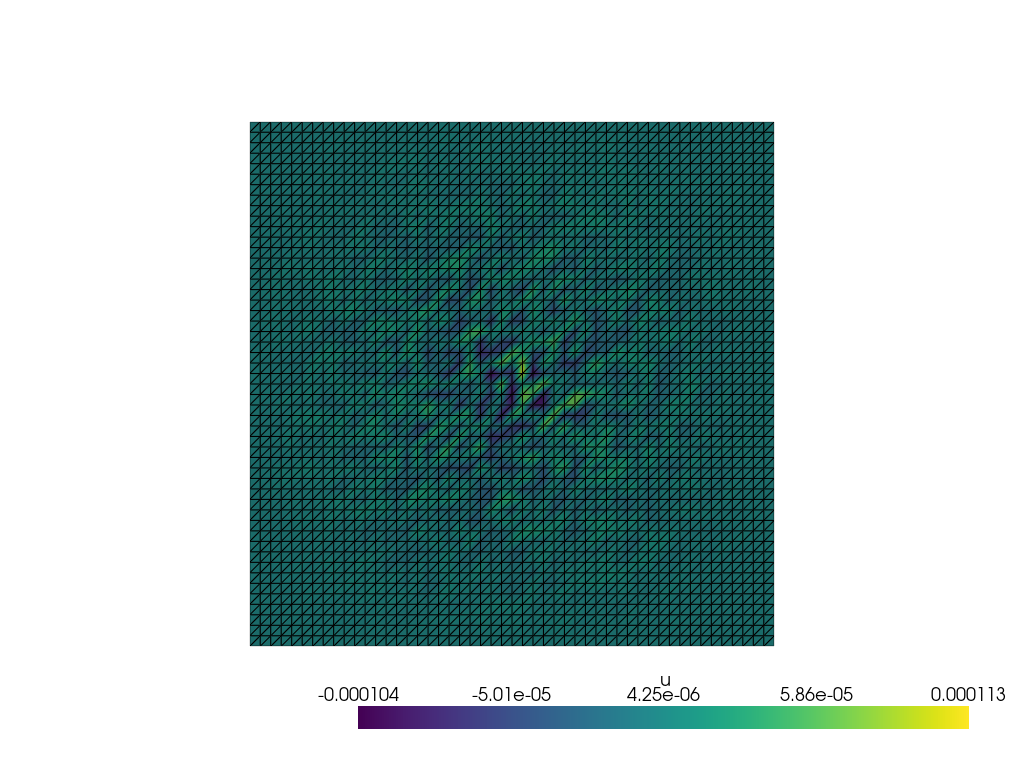

Delta level: 1.167713752837437e-05


In [48]:
#
u_delta = dolfinx.fem.Function(V)
u_delta.x.array[:] = u.x.array + u.x.array*(perc/100)*noise_vec
print("Plot of u^delta")
problem.plotFunc(u_delta)

delta_func = dolfinx.fem.Function(V)
delta_func.x.array[:] = u.x.array - u_delta.x.array
print("Plot u-u^delta")
problem.plotFunc(delta_func)

delta = funcSquareNorm(delta_func)**0.5
print("Delta level:",delta)


### Solving

In [55]:
%autoreload
inv_problem = InverseProblem(problem)

In [58]:
ck1, kdelta1, err_array1, res_array1 = inv_problem.inLM([u_delta],[fi],c,tau=1.1,delta=delta, alpha=0,lmbda=0.1,lmbda_mult=0.9)

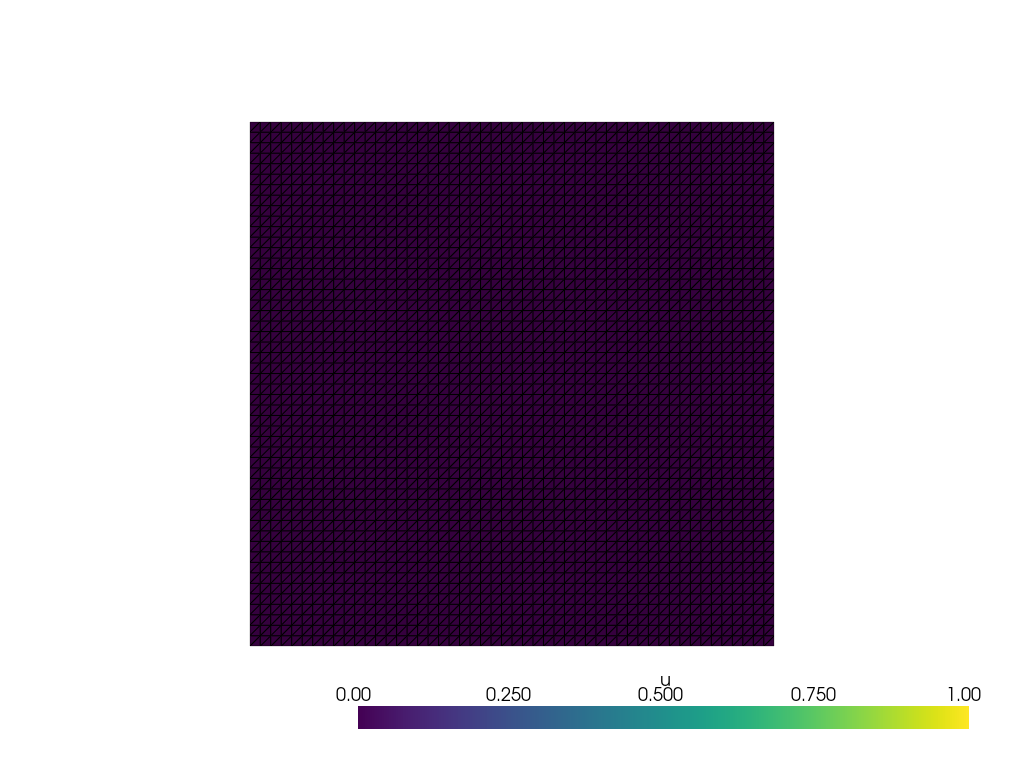

In [59]:
problem.plotFunc(ck1)

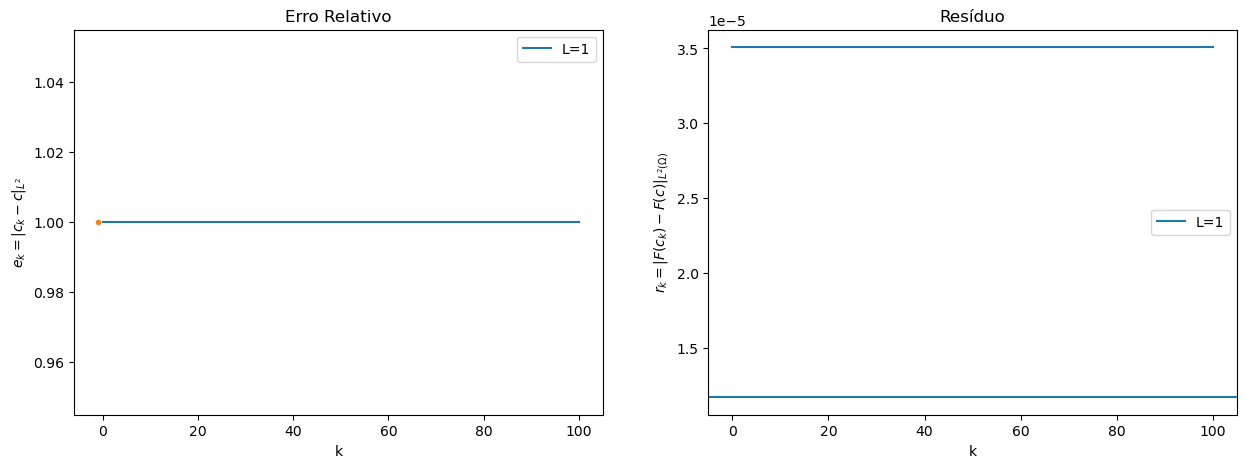

In [54]:
c_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(c,c) * ufl.dx))**0.5


fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array1/c_norm,label='L=1')
ax[0].plot([kdelta1],[err_array1[kdelta1]/c_norm],linestyle = '',marker='.')
ax[0].set_title("Erro Relativo")
ax[0].set_ylabel("$e_k = \|c_k - c\|_{L^2}$")
ax[0].set_xlabel("k")
ax[0].legend()

ax[1].plot(res_array1,label='L=1')
ax[1].set_title("Resíduo")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
ax[1].legend()
ax[1].axhline(y=1*delta)
plt.show()


## Multiple equations

In [38]:
n_points = 4
index_array = np.linspace(0,(N+1),(n_points)+2,dtype=int)[1:-1]
index_grid = np.dstack(np.meshgrid(index_array, index_array)).reshape(-1, 2)
index_grid

f_list2 = [dolfinx.fem.Function(V) for i in range(n_points**2)]
for i in range(n_points**2):
  fi = f_list2[i]
  index_i = problem.M_id[index_grid[i][0]][index_grid[i][1]]

  fi.x.array[index_i] = 10

uB = dolfinx.fem.Function(V)
uB.x.array[:] = 1
L = n_points**2
u_list = problem.directOperator(c,f_list2,uB)

u_norm_sum = 0
for k in range(L):
    u_norm_sum += funcSquareNorm(u_list[k])
u_list2_norm = (u_norm_sum/L)**0.5


In [ ]:
u

In [12]:
L=1
lmbda = 0.01
alpha = 0.99
c0  = dolfinx.fem.Function(V) #inicializa c0=0
n_iter = 900
list_residuo = [dolfinx.fem.Function(V) for i in range(L)]
c_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(c,c) * ufl.dx))**0.5

err_func = dolfinx.fem.Function(V)

err_array_2f = np.zeros(n_iter+1)
res_array_2f = np.zeros(n_iter+1)

ck_2f = c0
bk = [dolfinx.fem.Function(V) for i in range(L)]
ck_old = dolfinx.fem.Function(V)
wk = dolfinx.fem.Function(V)

for i in range(n_iter):
  err_func.x.array[:] = ck_2f.x.array-c.x.array
  err_array_2f[i] = funcSquareNorm(err_func)**0.5
  list_uk = directOperator(ck_2f,f_list2,uB)
  res_sum = 0

  wk.x.array[:] = ck_2f.x.array + alpha*(ck_2f.x.array - ck_old.x.array)

  #calcula residuo e bk
  for k in range(L):
    list_residuo[k].x.array[:] = list_uk[k].x.array - u_list[k].x.array
    res_sum += funcSquareNorm(list_residuo[k])

    bk[k].x.array[:] = - list_residuo[k].x.array
  res_array_2f[i] = (res_sum/L)**0.5

  #calcula (Ak)^* bk
  adj_bk = directOperatorAdjoint(bk, wk, list_uk)

  #define ((Ak)^*Ak + lmbda I)
  Ak = lambda x: tikhonovOp(x, lmbda, wk, list_uk)

  #calcula sk
  sk = conjugateGradient(Ak,adj_bk,dolfinx.fem.Function(V),tol=1e-10,maxit=3)

  #atualiza ck
  ck_old.x.array[:] = ck_2f.x.array
  ck_2f.x.array[:] = wk.x.array + sk.x.array

  lmbda /= 1


list_uk = directOperator(ck_2f,uB,f_list2)
res_sum = 0
for k in range(L):
  list_residuo[k].x.array[:] = list_uk[k].x.array - u_list[k].x.array
  res_sum += funcSquareNorm(list_residuo[k])
res_array_2f[-1] = (res_sum/L)**0.5

err_array_2f[-1] = funcSquareNorm(ck_2f-c)**0.5


NameError: name 'uB' is not defined

In [11]:
ufl.inner(ck_2f-c,ck_2f-c)*ufl.dx

ValueError: Multiple domains found, making the choice of integration domain ambiguous.